<a href="https://colab.research.google.com/github/Ppangchon/project/blob/main/acc65.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ModelOCT 

In [1]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import glob
import PIL
import plotly
import shutil
import plotly.graph_objs as go
import pandas as pd
from numpy import array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, AveragePooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D)
import time
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
import requests
from IPython.display import Image
from io import BytesIO  
import pickle as p 
import plotly.graph_objs as go  
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
K.image_data_format()
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

## เตรียมชุดของข้อมูล

In [3]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์
path = '/content/drive/My Drive/OCTfinal'  # data เราอยู่โฟล์เดอร์ไหน

In [5]:
batch_size = 32   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 256  # ความสูงของรูปภาพแต่ละรูป
img_width = 256   # ความกว้างของรูปภาพแต่ละรูป

num_classes = 4

## Train

In [6]:
# Train
train_dir = "/content/drive/My Drive/OCTfinal/train"
train_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 17745 images belonging to 4 classes.


In [7]:
print('Train')
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนภาพของคลาส

Train
[0 1 2 3]
[4518 4469 4385 4373]


In [8]:
train_set[0][0][0].shape   # W*H*3 (3 Channel RGB) 

(256, 256, 3)

## Validation

In [9]:
# Validation
val_dir ="/content/drive/My Drive/OCTfinal/validation"
val_datagen = ImageDataGenerator(rescale = 1./255)

val_set = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 2216 images belonging to 4 classes.


In [10]:
print('Validation')
ids, counts = np.unique(val_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนข้อมูลของคลาส

Validation
[0 1 2 3]
[527 546 540 603]


## Test

In [11]:
# Test
test_dir ="/content/drive/My Drive/OCTfinal/test"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(img_height, img_width))

Found 2182 files belonging to 4 classes.


In [12]:
class_names = test_set.class_names
print(class_names)

['CSC', 'NORMAL', 'PCV', 'VKH']


## Training 

### สร้าง Model

In [64]:
num_classes = 4
epochs=20   # จำนวนครั้งที่เราจะ Train

# ขนาดภาพอินพุตเข้าสู่ Model
in_shape = (256,256,3)
in_shape


(256, 256, 3)

In [205]:
model = Sequential()   # สร้าง Model

# สร้างชั้น Convolution ชั้นแรก ค่าพารามิเตอร์ activation ใช้ ReLU
model.add(Conv2D(64, (3,3), activation = 'relu', input_shape = in_shape))
model.add(MaxPool2D((2,2)))    # สร้างชั้น Max Pooling ค่าพารามิเตอร์ 2,2 คือ Pool Size

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

# FULLY CONNECTED LAYER แปลง Feature Maps ในชั้น Convolutional Layer เป็น Vector
model.add(Flatten())

# Output layer
model.add(Dense(4, activation='softmax')) # 4 คลาส
model.summary()          # ดูสรุปโครงสร้าง Model

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 30, 30, 128)    

##### ดู kernel

In [ ]:
for layer in model.layers:
  if 'conv' not in layer.name:
       continue
  kernels, biases = layer.get_weights()
  print(layer.name, 'shape:', kernels.shape)

conv2d shape: (3, 3, 3, 16)
conv2d_1 shape: (3, 3, 16, 32)
conv2d_2 shape: (3, 3, 32, 64)


In [ ]:
k_min, k_max = kernels.min(), kernels.max()
kernels = (kernels - k_min)/ (k_max - k_min)
kernel_idx = 0
kernel_i = kernels[:, :, 0, kernel_idx]
print(kernel_i.round(2))

[[0.16 0.44 0.77]
 [0.17 0.54 0.21]
 [0.71 0.38 0.69]]


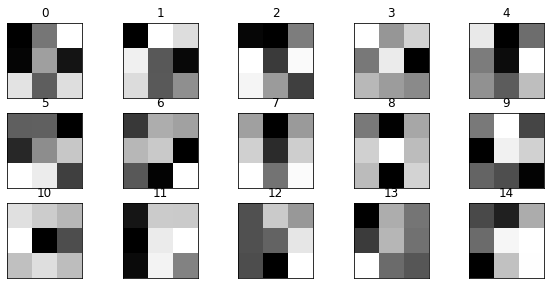

In [ ]:
nplots = 15
fig = plt.figure(figsize = (10, 8))
for j in range(nplots):
  plt.subplot(5, 5, j+1)
  plt.imshow(kernels[:, :, 0, j], cmap = plt.cm.gray)
  plt.title(j)
  plt.xticks([]); plt.yticks([])
plt.show()

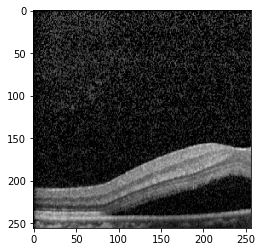

In [ ]:
image = load_img('/content/drive/My Drive/trycode/train/CSC/IA3870 19-12-16 RE_000_cropped.png', target_size=(256, 256))
plt.imshow(image)
plt.show()

In [ ]:
img1 = img_to_array(image)
print('shape =', img1.shape)
print('max pixel value =', np.max(img1))

shape = (256, 256, 3)
max pixel value = 240.0


### Compile และ Train

In [206]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [207]:
start = time.time()

history = model.fit(train_set, steps_per_epoch=len(train_set), 
                    validation_data=val_set, 
                    epochs=epochs,verbose=1)

end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/20
555/555 [==============================] - 189s 332ms/step - loss: 1.1021 - accuracy: 0.4862 - val_loss: 1.0029 - val_accuracy: 0.5772
Epoch 2/20
555/555 [==============================] - 178s 321ms/step - loss: 0.5286 - accuracy: 0.7940 - val_loss: 1.1892 - val_accuracy: 0.5930
Epoch 3/20
555/555 [==============================] - 170s 306ms/step - loss: 0.3076 - accuracy: 0.8816 - val_loss: 0.9276 - val_accuracy: 0.6949
Epoch 4/20
555/555 [==============================] - 171s 308ms/step - loss: 0.1949 - accuracy: 0.9276 - val_loss: 1.0929 - val_accuracy: 0.6764
Epoch 5/20
555/555 [==============================] - 166s 298ms/step - loss: 0.1263 - accuracy: 0.9541 - val_loss: 1.4954 - val_accuracy: 0.6823
Epoch 6/20
555/555 [==============================] - 166s 298ms/step - loss: 0.0887 - accuracy: 0.9682 - val_loss: 1.9510 - val_accuracy: 0.6579
Epoch 7/20
555/555 [==============================] - 169s 304ms/step - loss: 0.0782 - accuracy: 0.9727 - val_loss: 2.2599 -

### Save Model

In [208]:
modelOCT = '/Model'
if not os.path.exists(path+modelOCT):
    os.makedirs(path+modelOCT)
os.makedirs('/content/drive/My Drive/OCTfinal/savemodel/', exist_ok=True)
model.save('/content/drive/MyDrive/OCTfinal/savemodel/OCTmodel8.h5')
with open('history_model', 'wb') as file:
   p.dump(history.history, file)

filepath='OCTmodel8.h5'
model.save(filepath)
filepath_model = 'OCTmodel8.json'
filepath_weights = 'weights_OCTmodel8.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weights_OCTmodel8.h5')
print("Saved model to disk")
     

Saved model to disk


### Load Model

In [209]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['val_accuracy'],
mode="lines", line=dict(
width=2,
color='blue'),
name="val_accuracy"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testOCT")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 30, 30, 128)    

## ประเมิน

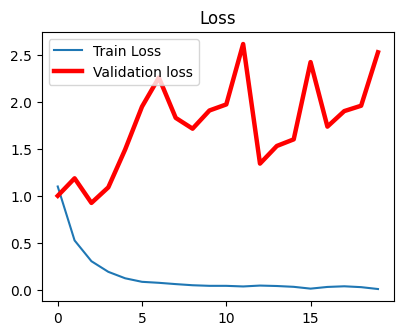

In [210]:
plt.figure(figsize = (10, 3.5))
plt.subplot(1, 2 , 1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], 'r', lw = 3.2, label = 'Validation loss')
plt.legend()

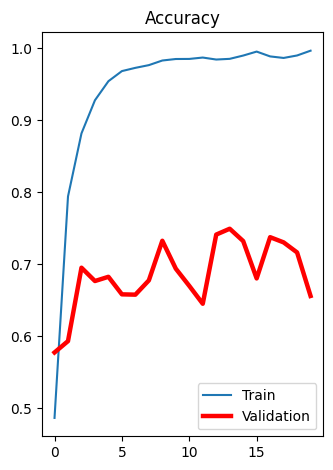

In [211]:
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], 'r', lw = 3.2, label = 'Validation')
plt.legend()
plt.tight_layout()
plt.show()

In [212]:
acc = model.evaluate(val_set, steps = len(val_set), verbose = 0)
print('score = {:.3f}' .format(acc[1]))

score = 0.656


### Prediction

In [113]:
import requests
from IPython.display import Image
from io import BytesIO
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing import image 
import keras.utils as image
from keras.models import load_model

In [114]:
train_set.class_indices

{'CSC': 0, 'NORMAL': 1, 'PCV': 2, 'VKH': 3}

1/1 [==============================] - 0s 307ms/step
CSC tf.Tensor(0.47536686, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


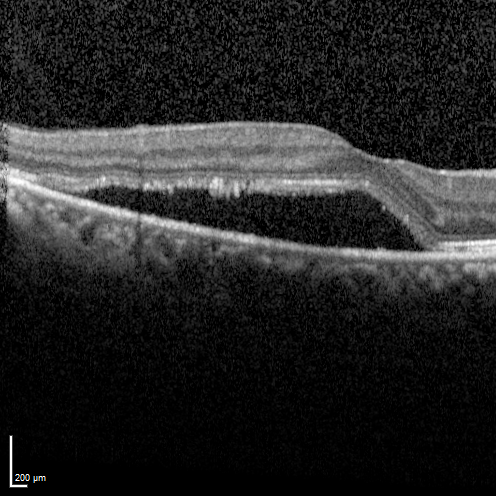

AI CSC มีความมั่นใจ 47.54%.


In [115]:
# CSC
test_path = ('/content/drive/My Drive/OCTfinal/test/CSC/IA3870 09-01-17 RE_002008_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 25ms/step
CSC tf.Tensor(0.47536686, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


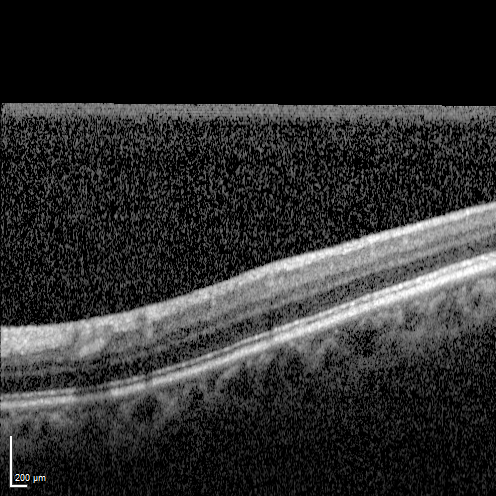

AI CSC มีความมั่นใจ 47.54%.


In [116]:
# Normal
test_path = ('/content/drive/My Drive/OCTfinal/test/NORMAL/ED8056 05-05-17 LE_001020_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 25ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.47536686, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


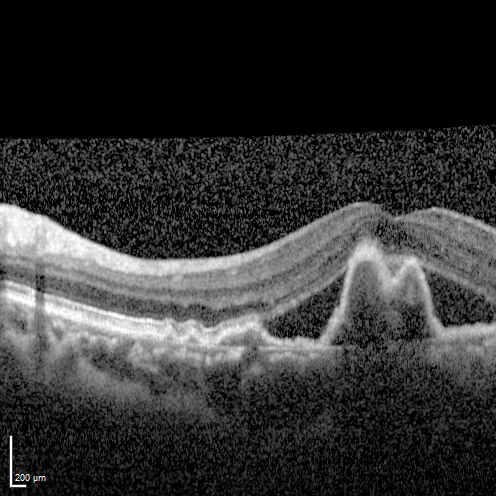

AI PCV มีความมั่นใจ 47.54%.


In [117]:
# PCV
test_path = ('/content/drive/My Drive/OCTfinal/test/PCV/BF9378 23-09-18 LE_002009_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 25ms/step
CSC tf.Tensor(0.47536686, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


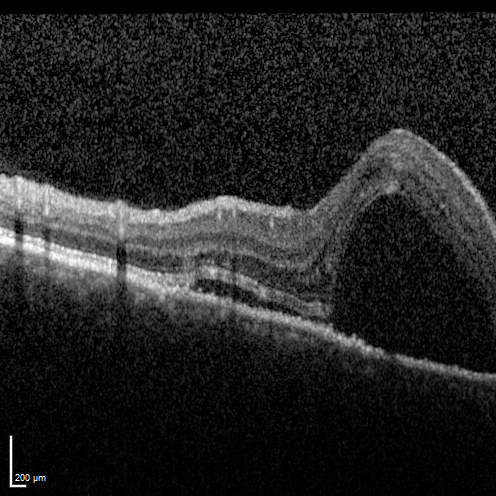

AI CSC มีความมั่นใจ 47.54%.


In [118]:
# VKH
test_path = ('/content/drive/My Drive/OCTfinal/test/VKH/KN4858 21-02-22 RE_002001_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

### Testing

In [213]:
test_set_ = test_set.unbatch()

In [214]:
test_set.file_paths

['/content/drive/My Drive/OCTfinal/test/PCV/AV0940 20-02-15 RE_001005_cropped.png',
 '/content/drive/My Drive/OCTfinal/test/VKH/KH7322 18-12-20 RE_002008_cropped.png',
 '/content/drive/My Drive/OCTfinal/test/PCV/BF9378 23-09-18 LE_002002_cropped.png',
 '/content/drive/My Drive/OCTfinal/test/NORMAL/DC9532 22-12-16 RE_001002_cropped.png',
 '/content/drive/My Drive/OCTfinal/test/NORMAL/CS5799 08-09-20 RE_001008_cropped.png',
 '/content/drive/My Drive/OCTfinal/test/CSC/GD4303_001005_cropped.png',
 '/content/drive/My Drive/OCTfinal/test/NORMAL/DL9765 25-05-18 RE_002003_cropped.png',
 '/content/drive/My Drive/OCTfinal/test/VKH/KH7322 18-12-20 LE_001019_cropped.png',
 '/content/drive/My Drive/OCTfinal/test/CSC/IA3870 09-01-17 RE_001018_cropped.png',
 '/content/drive/My Drive/OCTfinal/test/VKH/KI2719 02-02-21 LE009_cropped.png',
 '/content/drive/My Drive/OCTfinal/test/CSC/FQ8979 23-03-12 RE_001012_cropped.png',
 '/content/drive/My Drive/OCTfinal/test/PCV/AV0940 22-08-17 RE_002011_cropped.png',

In [215]:
len(test_set.file_paths)

2182

In [216]:
import shutil

In [ ]:
myFilename

'/content/drive/My Drive/trycode/test/VKH/KI2719 02-02-21 RE_001005_cropped.png'

In [217]:
misclass_path = '/misclassify_model8'
if not os.path.exists(path+misclass_path):
    os.makedirs(path+misclass_path)

for myFilename in test_set.file_paths:

  tempfn = myFilename.split('/')
  myTrueVal = tempfn[6]
  mySubjID = tempfn[7].rstrip('_cropped.png')

  test_path = (myFilename)
  img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
    )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = predict_model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  if score[0]==np.max(score):
    eye = "CSC"
  elif score[1]==np.max(score):
    eye = "NORMAL"
  elif score[2]==np.max(score):
    eye = "PCV"
  elif score[3]==np.max(score):
    eye = "VKH"
  myConfid = np.round(100 * np.max(score),2)
  myPredVal = eye 

  if myTrueVal != myPredVal:
    fn = mySubjID+'__true-'+myTrueVal+'__pred-'+myPredVal+'__'+str(myConfid)+'.png'
    print(fn)
    shutil.copyfile(myFilename, path+misclass_path+'/'+fn)

1/1 [==============================] - 0s 30ms/step
KH7322 18-12-20 RE_002008__true-VKH__pred-CSC__47.54.png
1/1 [==============================] - 0s 47ms/step
DC9532 22-12-16 RE_001002__true-NORMAL__pred-VKH__47.54.png
1/1 [==============================] - 0s 39ms/step
CS5799 08-09-20 RE_001008__true-NORMAL__pred-CSC__47.54.png
1/1 [==============================] - 0s 67ms/step
IA3870 09-01-17 RE_001018__true-CSC__pred-NORMAL__47.54.png
1/1 [==============================] - 0s 26ms/step
GE3946 31-08-17 RE_001021__true-CSC__pred-VKH__47.54.png
1/1 [==============================] - 0s 28ms/step
IA3870 09-01-17 RE_002000__true-CSC__pred-NORMAL__47.54.png
1/1 [==============================] - 0s 26ms/step
IA2051 25-11-11 RE_000011__true-CSC__pred-NORMAL__47.54.png
1/1 [==============================] - 0s 27ms/step
AV0940 27-12-11 RE_001021__true-PCV__pred-NORMAL__47.54.png
1/1 [==============================] - 0s 27ms/step
GD7863 12-16-16 RE_001024__true-CSC__pred-VKH__47.54.png
1

In [218]:
myImages = list(test_set_.map(lambda x, y: x))
myLabels = list(test_set_.map(lambda x, y: y))

In [219]:
print(len(myImages),len(myLabels))

2182 2182


In [220]:
y_test = []; y_pred = []
class_names = test_set.class_names
for images, labels in test_set:
  for i in range(len(list(labels))):
    img_array = keras.preprocessing.image.img_to_array(images[i])
    X_test = tf.expand_dims(img_array, 0)
    score = predict_model.predict(X_test)
    if score[0][0]==np.max(score):
      eye = "CSC"
    elif score[0][1]==np.max(score):
      eye = "NORMAL"
    elif score[0][2]==np.max(score):
      eye = "PCV"
    elif score[0][3]==np.max(score):
      eye = "VKH"
    y_pred.append(eye)
    y_test.append(class_names[labels[i]])

1/1 [==============================] - 0s 19ms/step


In [221]:
print(y_test)
print(len(y_test))

['NORMAL', 'PCV', 'CSC', 'VKH', 'VKH', 'VKH', 'PCV', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'CSC', 'CSC', 'CSC', 'VKH', 'PCV', 'CSC', 'PCV', 'VKH', 'PCV', 'NORMAL', 'NORMAL', 'CSC', 'NORMAL', 'NORMAL', 'VKH', 'VKH', 'CSC', 'VKH', 'PCV', 'VKH', 'NORMAL', 'NORMAL', 'CSC', 'PCV', 'NORMAL', 'VKH', 'NORMAL', 'CSC', 'VKH', 'CSC', 'NORMAL', 'NORMAL', 'NORMAL', 'PCV', 'PCV', 'PCV', 'NORMAL', 'PCV', 'PCV', 'CSC', 'NORMAL', 'NORMAL', 'PCV', 'NORMAL', 'NORMAL', 'PCV', 'NORMAL', 'NORMAL', 'VKH', 'VKH', 'CSC', 'PCV', 'PCV', 'VKH', 'VKH', 'CSC', 'PCV', 'NORMAL', 'NORMAL', 'NORMAL', 'CSC', 'NORMAL', 'CSC', 'CSC', 'NORMAL', 'PCV', 'NORMAL', 'NORMAL', 'PCV', 'PCV', 'NORMAL', 'NORMAL', 'CSC', 'CSC', 'NORMAL', 'VKH', 'CSC', 'CSC', 'VKH', 'CSC', 'NORMAL', 'CSC', 'PCV', 'NORMAL', 'CSC', 'VKH', 'CSC', 'NORMAL', 'NORMAL', 'VKH', 'CSC', 'PCV', 'VKH', 'CSC', 'CSC', 'VKH', 'PCV', 'VKH', 'PCV', 'VKH', 'CSC', 'CSC', 'NORMAL', 'CSC', 'PCV', 'CSC', 'NORMAL', 'VKH', 'CSC', 'PCV', 'PCV', 'NORMAL', 'VKH', 'PCV', 'NOR

In [222]:
print(y_pred)
print(len(y_pred))

['NORMAL', 'NORMAL', 'CSC', 'VKH', 'VKH', 'VKH', 'CSC', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'CSC', 'CSC', 'VKH', 'VKH', 'PCV', 'NORMAL', 'PCV', 'VKH', 'PCV', 'NORMAL', 'NORMAL', 'VKH', 'NORMAL', 'CSC', 'VKH', 'VKH', 'CSC', 'VKH', 'PCV', 'CSC', 'NORMAL', 'NORMAL', 'NORMAL', 'CSC', 'PCV', 'PCV', 'PCV', 'CSC', 'CSC', 'CSC', 'NORMAL', 'NORMAL', 'NORMAL', 'PCV', 'PCV', 'NORMAL', 'PCV', 'CSC', 'PCV', 'CSC', 'NORMAL', 'VKH', 'PCV', 'NORMAL', 'NORMAL', 'PCV', 'NORMAL', 'VKH', 'VKH', 'VKH', 'NORMAL', 'NORMAL', 'PCV', 'PCV', 'PCV', 'CSC', 'PCV', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'CSC', 'NORMAL', 'PCV', 'NORMAL', 'NORMAL', 'PCV', 'PCV', 'NORMAL', 'NORMAL', 'PCV', 'CSC', 'CSC', 'VKH', 'CSC', 'CSC', 'NORMAL', 'CSC', 'NORMAL', 'VKH', 'PCV', 'NORMAL', 'CSC', 'VKH', 'VKH', 'VKH', 'NORMAL', 'VKH', 'VKH', 'PCV', 'VKH', 'NORMAL', 'NORMAL', 'VKH', 'NORMAL', 'VKH', 'CSC', 'VKH', 'NORMAL', 'NORMAL', 'VKH', 'CSC', 'VKH', 'NORMAL', 'NORMAL', 'VKH', 'CSC', 'PCV', 'NORMAL', 'CSC', 

## Confusion Matrix

In [223]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [224]:
confusion_matrix(y_test, y_pred)

array([[271, 142,  37, 102],
       [ 50, 434,  27,  59],
       [ 29, 142, 269,  88],
       [ 41,  27,  24, 440]])

In [225]:
cm = confusion_matrix(y_test, y_pred)

In [226]:
test_set.class_names

['CSC', 'NORMAL', 'PCV', 'VKH']

In [227]:
cm_df = pd.DataFrame(cm,
                     index = ['CSC', 'NORMAL', 'PCV', 'VKH'], 
                     columns = ['CSC', 'NORMAL', 'PCV', 'VKH'])

In [228]:
cm_df

,CSC,NORMAL,PCV,VKH
CSC,271,142,37,102
NORMAL,50,434,27,59
PCV,29,142,269,88
VKH,41,27,24,440


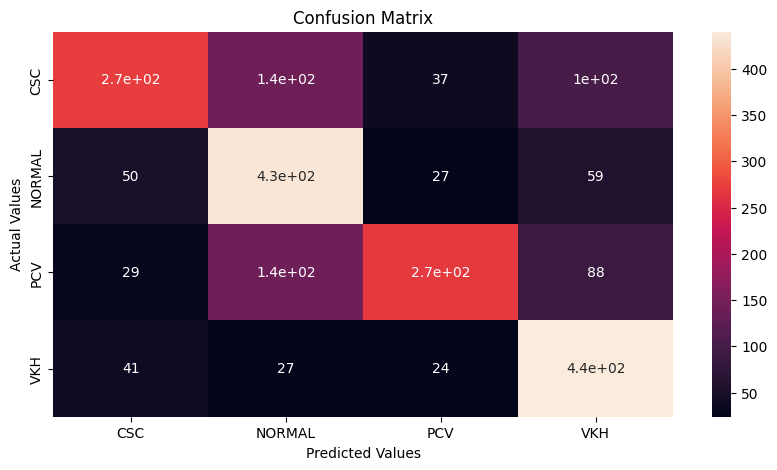

In [229]:
plt.figure(figsize=(10,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
     

#### ตัวชี้วัด

In [230]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [231]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.648029


In [232]:
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Recall: %f' % recall)

Recall: 0.648029


In [233]:
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Precision: %f' % precision)

Precision: 0.665550


In [234]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('F1 score: %f' % f1)

F1 score: 0.640656


##  misclassify

In [235]:
# แสดง misclassify ว่ามีกี่ค่า
misclassify = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:
            misclassify += cm[i][j]
            
print('misclassification: ', misclassify)

misclassification:  768


In [236]:
# คำนวณค่า misclassification
misclassify = 1 - np.trace(cm) / np.sum(cm)

# Misclassification rate = จำนวนภาพที่ถูกจัดหมวดหมู่ผิด / จำนวนภาพทั้งหมดที่ใช้ในการทดสอบ

# แสดงผลลัพธ์ที่คิดเป็น %
print("Misclassification: {:.2f}%".format(misclassify*100))

Misclassification: 35.20%


#### ลองดึงภาพผิดไป 1 ภาพ

In [ ]:
# get class labels
class_labels = ['CSC', 'Normal', 'PCV', 'VKH']

In [ ]:
# load the saved model
model = load_model('modelOCT.h5')

In [ ]:
# load the test image
#test_image = image.load_img('/content/drive/My Drive/trycode/test/CSC/GD7863 12-16-16 RE_000_cropped.png', target_size=(256, 256))

In [ ]:
# preprocess the test image
#test_image = image.img_to_array(test_image)
#test_image = np.expand_dims(test_image, axis=0)

In [ ]:
# make predictions
#result = model.predict(test_image)

1/1 [==============================] - 0s 71ms/step


In [ ]:
path  # data เราอยู่โฟล์เดอร์ไหน

'/content/drive/My Drive/trycode'

In [ ]:
model = keras.models.load_model('modelOCT.h5')
test_data = keras.preprocessing.image_dataset_from_directory(path+'/test/')

Found 152 files belonging to 4 classes.


In [ ]:
predictions = model.predict(test_data)

5/5 [==============================] - 1s 16ms/step


In [ ]:
import os
if not os.path.exists(path+'/misclassify'):
    os.makedirs(path+'/misclassify')
for i, image in enumerate(test_data):
  prediction = predictions[i]
  predicted_class = keras.backend.argmax(prediction).numpy()
  image_name = 'image555.png'.format(i)
  image_path = os.path.join(path+'/misclassify', image_name)
  keras.preprocessing.image.save_img(image_path, image[0][0])

## ลองวนลูปทำนายภาพในโฟลเดอร์

In [ ]:
#from sklearn.metrics import confusion_matrix

## สมมติว่าโมเดลเราคือ model
#cm = confusion_matrix(y_test, y_pred)

## หาค่า False Positive, False Negative, False Neutral, และ False Outlier
#fp = cm[0][1] + cm[0][2] + cm[0][3]
#fn = cm[1][0] + cm[2][0] + cm[3][0]
#fnr = fn / (fn + cm[1][1] + cm[1][2] + cm[1][3])
#fpr = fp / (fp + cm[1][0] + cm[2][0] + cm[3][0])
#outlier = cm[0][0] + cm[1][1] + cm[2][2] + cm[3][3]
#neutral = cm[1][2] + cm[1][3] + cm[2][1] + cm[2][3] + cm[3][1] + cm[3][2]

In [ ]:
## สมมติว่า y_train และ y_pred เป็น array ของข้อมูลฝึกสอนและผลการทำนายของโมเดลตามลำดับ
## โดยมีค่า class_labels เป็น list ของชื่อคลาส
## สร้าง confusion matrix
#confusion_mtx = confusion_matrix(y_test, y_pred)

## สร้าง dictionary เพื่อเก็บผลลัพธ์
#result = {}

## หา False Positive, False Negative, True Positive, และ True Negative ของแต่ละคลาส
#for i, label in enumerate(class_names):
#    fp = 0
#    fn = 0
#    tp = 0
#    tn = 0
#    try:
#        fp = len(y_pred[(y_test != i) & (y_pred == i)])
#        fn = len(y_pred[(y_test == i) & (y_pred != i)])
#        tp = len(y_pred[(y_test == i) & (y_pred == i)])
#        tn = len(y_pred[(y_test != i) & (y_pred != i)])
#    except IndexError:
#        pass
#    result[label] = {"False Positive": fp, "False Negative": fn, "True Positive": tp, "True Negative": tn}

## แสดงผลลัพธ์
#print("Evaluation Metrics for each class:")
#for label, metrics in result.items():
#    print(label)
#    for metric, value in metrics.items():
#        print("\t", metric, value)


In [ ]:
# สมมติว่า y_train และ y_pred เป็น array ของข้อมูลฝึกสอนและผลการทำนายของโมเดลตามลำดับ
# โดยมีค่า class_labels เป็น list ของชื่อคลาส
# สร้าง confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred)

# สร้างโฟลเดอร์ใหม่ที่จะเก็บภาพที่ทำนายผิด
new_folder_path = 'new_folder'
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
    
# สร้าง dictionary เพื่อเก็บผลลัพธ์
result = {}

# หา True Positive, False Positive, True Negative, และ False Negative ของแต่ละคลาส
for i, label in enumerate(class_names):
    tp = confusion_mtx[i][i]
    fp = np.sum(confusion_mtx, axis=0)[i] - tp
    fn = np.sum(confusion_mtx, axis=1)[i] - tp
    tn = np.sum(confusion_mtx) - tp - fp - fn
    result[label] = {"True Positive": tp, "False Positive": fp, "True Negative": tn, "False Negative": fn}

# แสดงผลลัพธ์
print("Evaluation Metrics for each class:")
for label, metrics in result.items():
    print(label)
    for metric, value in metrics.items():
        print("\t", metric, value)


In [ ]:
# หา index ของภาพที่ทำนายผิด
misclassified_idx = np.where((y_test == i) & (y_pred != i))[0]

# นำภาพที่ทำนายผิดไปเก็บไว้ในโฟลเดอร์อื่น ๆ และตั้งชื่อไฟล์ให้เหมาะสม
for idx in misclassified_idx:
    filename = f"actual_{label}_predicted_{class_names[y_pred[idx]]}_img{idx}.png"
    source_path = f"original_folder/img{idx}.png"
    destination_path = f"new_folder/{filename}"
    shutil.copyfile(source_path, destination_path)

In [ ]:
# กำหนด path ของภาพที่ทำนายผิด
wrong_pred_path = path+'/test'

# สร้าง list ของ tuple ที่ประกอบด้วยตำแหน่งภาพที่ทำนายผิด คำตอบจริง และคำตอบที่ทำนายได้
output_path = [(X_test[i], y_test[i], y_pred[i]) for i in misclassified_idx]

# วนลูปเพื่อเคลื่อนย้ายภาพที่ทำนายผิดไปยังโฟลเดอร์ misclassified
for i, (image_path, true_label, pred_label) in enumerate(output_path):
    # ชื่อไฟล์จริงของภาพ
    true_name = os.path.basename(image_path)
    # ตั้งชื่อไฟล์ใหม่โดยเติมคำว่า 'misclassified_' ไปข้างหน้าชื่อไฟล์
    new_name = f"misclassified_{true_name}"
    # สร้าง path ของไฟล์ใหม่
    new_path = os.path.join(output_dir, "misclassified", new_name)
    # คัดลอกไฟล์ภาพไปยังโฟลเดอร์ใหม่
    shutil.copyfile(image_path, new_path)
    # แสดงผลลัพธ์การตั้งชื่อไฟล์ใหม่
    print(f"Moved {true_name} to {new_name}")

In [ ]:
# กำหนด path ของโฟลเดอร์ที่มีไฟล์ภาพ
folder_path = '/content/drive/My Drive/trycode/test/'

# ดึงรายชื่อไฟล์ภาพทั้งหมดในโฟลเดอร์
image_files = os.listdir(folder_path)

# สร้าง X_test เป็น numpy array ที่มี shape (จำนวนภาพ, ความสูง, ความกว้าง, จำนวนช่องสี)
X_test = np.zeros((len(image_files), 256, 256, 3))

# วนลูปเพื่อโหลดและแปลงรูปภาพในแต่ละไฟล์เป็น numpy array
for cm, file_name in enumerate(image_files):
    # โหลดรูปภาพเป็น numpy array
    img = cv2.imread(os.path.join(folder_path, file_name))


    # นำ numpy array ของรูปภาพมาเก็บไว้ใน X_test
    X_test[cm] = img

In [ ]:
# ดึงรูปภาพที่ทำนายผิดจากชุดข้อมูล test
# ค้นหาตัวอย่างที่มีการทำนายผิดพลาดโดยพิจารณาจากค่าที่ทำนายได้และค่าจริงของแต่ละภาพ
misclassified_indices = np.where((y_test != y_pred) & (cm > 0))[0]

# ดึงรูปภาพจากชุดข้อมูลที่ทำนายผิดครั้งแรก
idx = misclassified_indices[0]  